In [1]:
# Library Requirements. 
import os, re, time, logging, requests
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import acf, pacf 
from statsmodels.stats.diagnostic import acorr_ljungbox

# Configure logging to provide timestamped messages for information and error reporting. 
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# Class 1: Data acquisition and automation. 
class VacanciesAcquisition:     
    def __init__(self, data_dir="ONS_UK_Vacancies"): 
        # Define the directory for storing downloaded CSV files. 
        self.data_dir = data_dir
        os.makedirs(self.data_dir, exist_ok=True)  

    def download_csv_files(self, start=117, end=58, delay_seconds=3): 
        # Iterate over the specified range of vintages. 
        for i in range(start, end - 1, -1): 
            # Construct the URL for each vintage release. 
            URL = f"https://www.ons.gov.uk/generator?format=csv&uri=/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/timeseries/ap2y/lms/previous/v{i}"
            # Construct the local file name for saving the file. 
            filename = os.path.join(self.data_dir, f"v{i}.csv")
            try: 
                # Send an HTTP GET request to the constructed URL. 
                response = requests.get(URL)
                response.raise_for_status()
                with open(filename, "wb") as f:
                    f.write(response.content)
                logging.info(f"Downloaded v{i}")
            except Exception as e:
                logging.warning(f"Failed to download v{i}: {e}")
            time.sleep(delay_seconds) # Insert a timed interval to prevent excessive load on the host server. 

In [3]:
# Class 2: Data preparation and structuring. 
class VacanciesStructuring:
    def __init__(self, data_dir="ONS_UK_Vacancies"): 
        # Define the directory containing the downloaded CSV files. 
        self.data_dir = data_dir

    def extract_vintage_date(self, filepath): 
        # Extract the release date (vintage) from the metadata header of the file. 
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                for line in f:
                    if "Release date" in line:
                        match = re.search(r'\d{2}-\d{2}-\d{4}', line)
                        if match:
                            return pd.to_datetime(match.group(), format="%d-%m-%Y")
        except Exception as e:
            logging.warning(f"Error reading vintage from {filepath}: {e}")
        return pd.NaT # Return a missing timestamp if extraction fails. 

    def parse_monthly_series(self, filepath): 
        # Parse the monthly time series data from the file. 
        vintage = self.extract_vintage_date(filepath)
        try:
            df = pd.read_csv(filepath, header=None, names=["RawDate", "Value"], encoding='utf-8')
            df = df[df["RawDate"].str.match(r"\d{4} [A-Z]{3}", na=False)] # Retain only rows with valid monthly dates. 
            df["Date"] = pd.to_datetime(df["RawDate"].str.title(), format="%Y %b", errors="coerce")
            df["Value"] = pd.to_numeric(df["Value"].astype(str).str.replace('"', ''), errors="coerce")
            df["Vintage"] = vintage # Label each observation with its corresponding vintage date. 
            df = df.dropna(subset=["Date", "Value"])
            return df[["Date", "Value", "Vintage"]] if not df.empty else pd.DataFrame()
        except Exception as e:
            logging.error(f"Error processing {filepath}: {e}")
            return pd.DataFrame()

    def consolidate_all_data(self): 
        # Aggregate all valid monthly datasets into a single DataFrame. 
        dataframes = []
        for file in os.listdir(self.data_dir):
            full_path = os.path.join(self.data_dir, file)
            df = self.parse_monthly_series(full_path)
            if not df.empty:
                dataframes.append(df)
        if dataframes:
            return pd.concat(dataframes, ignore_index=True)
        else:
            raise ValueError("No valid dataframes to consolidate.")

In [4]:
# Visualisation Function. 
def create_visualisations(all_data): 
    # Add a formatted label for each month and export the consolidated dataset. 
    all_data["MonthLabel"] = all_data["Date"].dt.strftime("%b %Y")
    all_data.to_csv("ONS_UK_Vacancies_Consolidated.csv", index=False, sep=";", encoding="utf-8")

    # Static Chart: Visualise revisions for February 2024 across vintages. 
    selected_month = pd.to_datetime("2024-02-01")
    selected_data = all_data[all_data["Date"] == selected_month].sort_values("Vintage")
    fig = px.line(selected_data, x="Vintage", y="Value", markers=True,
                  title="Revisions of UK Vacancy Estimates for February 2024",
                  labels={"Vintage": "Vintage (Release Date)", "Value": "Vacancy Estimate (thousands)"})
    fig.show()
    fig.write_html("vacancy_revisions_Feb2024.html")

    # Interactive Chart: Enable dropdown selection for viewing revisions across all months. 
    available_dates = all_data.drop_duplicates("Date").sort_values("Date")["Date"].tolist()
    default_month = pd.to_datetime("2024-01-01")

    fig = go.Figure()
    for date in available_dates:
        month_data = all_data[all_data["Date"] == date].sort_values("Vintage")
        fig.add_trace(go.Scatter(
            x=month_data["Vintage"], y=month_data["Value"],
            mode='lines+markers', name=date.strftime("%b %Y"),
            visible=(date == default_month)
        )) 

    # Configure dropdown functionality for month selection. 
    buttons = [dict(label=date.strftime("%b %Y"), method="update",
                    args=[{"visible": [d == date for d in available_dates]},
                          {"title": f"Revisions for {date.strftime('%b %Y')}"}])
               for date in available_dates]

    fig.update_layout(
        title=f"Revisions for {default_month.strftime('%b %Y')}",
        xaxis_title="Vintage (Release Date)",
        yaxis_title="Vacancy Estimate (thousands)",
        updatemenus=[dict(active=available_dates.index(default_month),
                          buttons=buttons, x=0.5, xanchor="center", y=1.15, yanchor="top")],
        template="plotly_white"
    )

    fig.show()
    fig.write_html("vacancy_revisions_dropdown.html")

In [5]:
# Forecasting Function. 
def forecast_vacancies(all_data, forecast_steps=6): 
    # Prepare the finalised time series by selecting the latest vintage for each month. 
    latest_data = all_data.sort_values("Vintage").groupby("Date").tail(1).sort_values("Date")
    ts = latest_data.set_index("Date")["Value"].asfreq('MS') 

    # Conduct the Augmented Dickey-Fuller test to assess stationarity. 
    result = adfuller(ts)
    logging.info(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    ts_diff = ts.diff().dropna() 

    # Generate ACF and PACF plots to inform model selection. 
    acf_values = acf(ts_diff, nlags=20)
    pacf_values = pacf(ts_diff, nlags=20)

    fig_acf_pacf = go.Figure()
    fig_acf_pacf.add_trace(go.Bar(x=list(range(len(acf_values))), y=acf_values, name="ACF", marker_color="steelblue"))
    fig_acf_pacf.add_trace(go.Bar(x=list(range(len(pacf_values))), y=pacf_values, name="PACF", marker_color="darkorange"))
    fig_acf_pacf.update_layout(title="ACF and PACF of Differenced Series", xaxis_title="Lag", yaxis_title="Correlation", barmode="group", template="plotly_white")
    fig_acf_pacf.show() 

    # Fit an ARIMA(1,1,1) model to the differenced series. 
    model = ARIMA(ts, order=(1, 1, 1))
    fitted = model.fit(cov_type="approx")
    logging.info(f"\n{fitted.summary()}") 

    # Perform the Ljung-Box test to check for residual autocorrelation. 
    ljung_box_results = acorr_ljungbox(fitted.resid, lags=[10], return_df=True)
    print("\nLjung-Box Test for Residual Autocorrelation:")
    print(ljung_box_results) 

    # Generate forecasts and confidence intervals. 
    pred = fitted.get_forecast(steps=forecast_steps)
    forecast = pred.predicted_mean
    conf_int = pred.conf_int()

    forecast_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
    forecast_df = pd.DataFrame({
        "Date": forecast_dates,
        "Forecast": forecast.values,
        "Lower": conf_int.iloc[:, 0].values,
        "Upper": conf_int.iloc[:, 1].values
    }) 

    # Combine historical and forecast data. 
    ts_df = ts.reset_index().rename(columns={"Value": "Forecast"})
    combined_df = pd.concat([ts_df, forecast_df], ignore_index=True) 

    # Visualise the forecast trajectory with its associated confidence intervals. 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ts_df["Date"], y=ts_df["Forecast"], mode='lines', name='Historical', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=forecast_df["Date"], y=forecast_df["Forecast"], mode='lines+markers', name='Forecast', line=dict(color='orange')))
    fig.add_trace(go.Scatter(
        x=list(forecast_df["Date"]) + list(forecast_df["Date"][::-1]),
        y=list(forecast_df["Upper"]) + list(forecast_df["Lower"][::-1]),
        fill='toself', fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,165,0,0)'), hoverinfo="skip",
        showlegend=True, name='Confidence Interval'
    ))

    fig.update_layout(title="Forecast of UK Vacancy Estimates with Confidence Intervals", xaxis_title="Date", yaxis_title="Vacancy Estimate (thousands)", template="plotly_white")
    fig.show()
    fig.write_html("vacancy_forecast.html")
    return forecast_df


2025-10-06 20:10:15,036 - INFO - Downloaded v117
2025-10-06 20:10:18,123 - INFO - Downloaded v116
2025-10-06 20:10:21,201 - INFO - Downloaded v115
2025-10-06 20:10:24,287 - INFO - Downloaded v114
2025-10-06 20:10:27,353 - INFO - Downloaded v113
2025-10-06 20:10:30,421 - INFO - Downloaded v112
2025-10-06 20:10:33,511 - INFO - Downloaded v111
2025-10-06 20:10:36,594 - INFO - Downloaded v110
2025-10-06 20:10:39,696 - INFO - Downloaded v109
2025-10-06 20:10:42,764 - INFO - Downloaded v108
2025-10-06 20:10:45,828 - INFO - Downloaded v107
2025-10-06 20:10:48,904 - INFO - Downloaded v106
2025-10-06 20:10:51,979 - INFO - Downloaded v105
2025-10-06 20:10:55,037 - INFO - Downloaded v104
2025-10-06 20:10:58,105 - INFO - Downloaded v103
2025-10-06 20:11:01,175 - INFO - Downloaded v102
2025-10-06 20:11:04,260 - INFO - Downloaded v101
2025-10-06 20:11:07,318 - INFO - Downloaded v100
2025-10-06 20:11:10,380 - INFO - Downloaded v99
2025-10-06 20:11:13,433 - INFO - Downloaded v98
2025-10-06 20:11:16,54

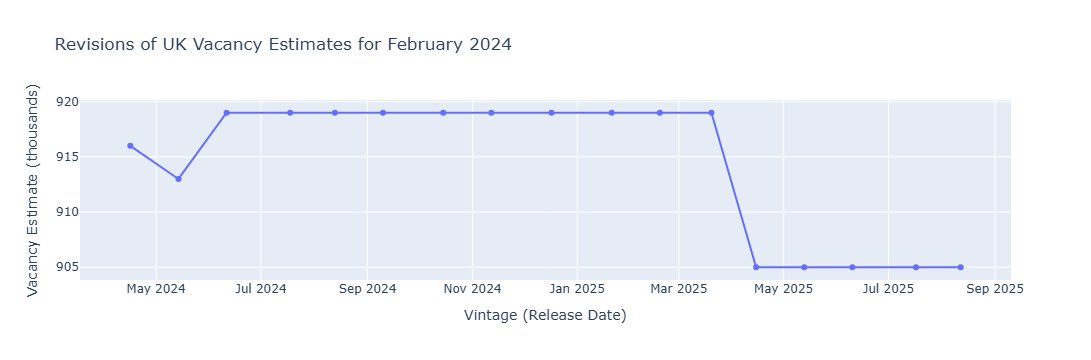

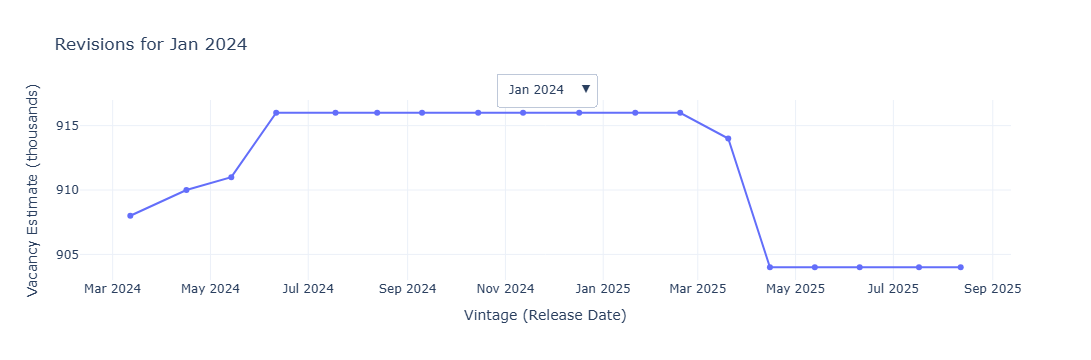

2025-10-06 20:13:28,036 - INFO - ADF Statistic: -1.8122, p-value: 0.3744


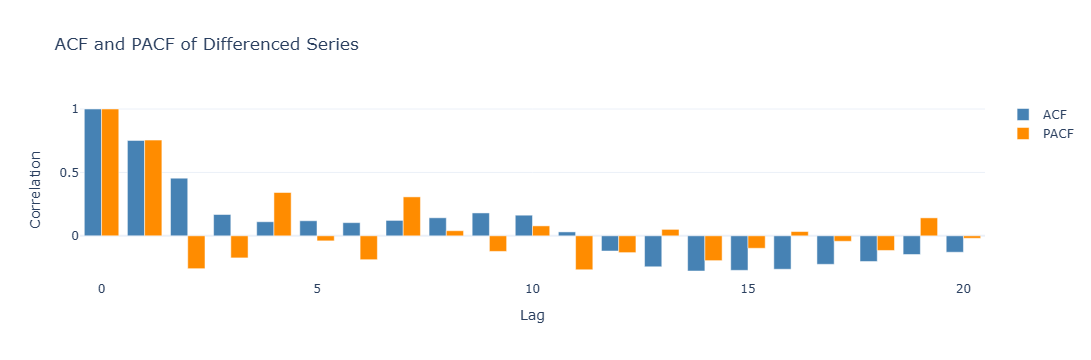

2025-10-06 20:13:28,247 - INFO - 
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1206.028
Date:                Mon, 06 Oct 2025   AIC                           2418.056
Time:                        20:13:28   BIC                           2429.056
Sample:                    05-01-2001   HQIC                          2422.464
                         - 06-01-2025                                         
Covariance Type:               approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6734      0.050     13.351      0.000       0.575       0.772
ma.L1          0.1953      0.054      3.592      0.000       0.089       0.302
sigma2       245.9


Ljung-Box Test for Residual Autocorrelation:
     lb_stat  lb_pvalue
10  1.774518   0.997794


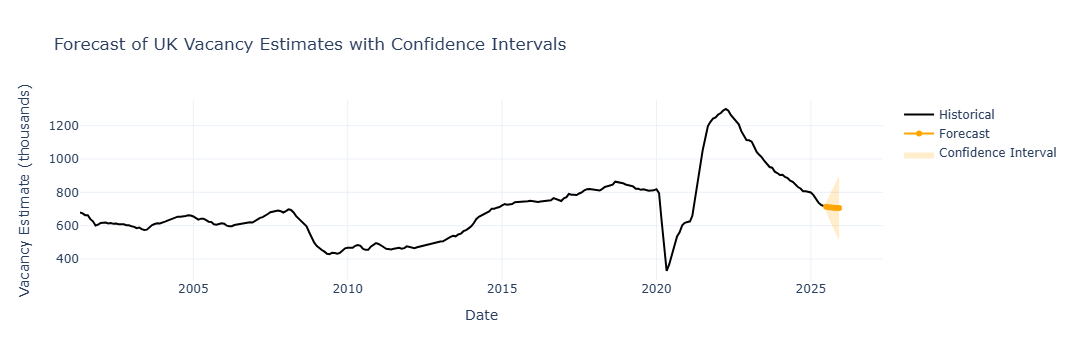

In [6]:
# Final Step: Execution of the classes and functions. 

if __name__ == "__main__": 
    vacancies = VacanciesAcquisition()
    vacancies.download_csv_files(start=117, end=58, delay_seconds=3)
    
    unified = VacanciesStructuring()
    all_data = unified.consolidate_all_data() 
    
    # Run visualisations. 
    create_visualisations(all_data) 
    
    # Run forecasts. 
    forecast_df = forecast_vacancies(all_data, forecast_steps=6) 